## Реализация Deep Q-learning на Python

### Импортирование модулей
Как уже отмечалось, в работе представлено решение задачи **Acrobot** из **OpenAI Gym Classic conctrol** с помощью **Deep Q-Network (DQN)**. Для этого импортируем несколько библиотек. На момент написания этой работы реализация кода немного устарела: некоторые модули имеют уже другую структуру. Поэтому приведем версии библиотек, которые гарантируют корректную работу программы.
* pyglet-1.5.27
* gym-0.21.0
* tensorflow-2.11.0

Импортируем вспомогательные модули

In [153]:
import os
import datetime
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt

Импортируем **OpenAI Gym**

In [154]:
import gym

Импортируем модуль **TensorFlow**. В данной задаче он импользуется для использования нейронки.

In [155]:
import tensorflow as tf

#Инициализируем некоторые объекты: выделение памяти, определение обычной сессии...
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True) 
config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)  
with tf.compat.v1.Session(config=config): pass          

Автором статьи создан довольно удобный файл, в котором представлено все необходимое для визуализации результатов. Предлагаем его скачать, а затем импортировать: https://marcinbogdanski.github.io/rl-sketchpad/Deep_Q_Network/helpers.py 

In [156]:
import helpers
import importlib
importlib.reload(helpers);

### Реализация Q-Learning


Как уже отмечалось, в реализации используется так называемый $\epsilon$-жадная стратегия, реализуемая следующей функцией.

In [157]:
def policy(st, model, eps):
    if np.random.rand() > eps:
        q_values = model.eval(np.stack([st]))
        return np.argmax(q_values)
    else:
        return env.action_space.sample()

Основная часть кода, которая представляет реализацию **Deep Q-Learning**, реализована в следующей функции. Стоит отметить, что тут же в коде используется стратегия **Decayed $\epsilon$-greedy**, т.е. та же самая $\epsilon$-жадная стратегия, только с уменьшающимся со временем $\epsilon$.

In [158]:
def q_learning(env, frames, gamma, eps_decay_steps, eps_target,
               batch_size, model, mem, start_step=0,
               callback=None, trace=None, render=False):
    """
    Функция для реализации Q-Learning
    Параметры:
        env - среда, для которой реализуется обучение
        frames - количество шагов, которые нужно выполнить
        gamma - параметр дисконтирования из [0..1]
        eps_decay_steps - временной параметр для реализации decayed epsilon-greedy
        eps_target - epsilon-greedy параметр после процесса "уменьшения" epsilon
        batch_size - batch size для нейронной нести 
        model      - объект класса TFFunctApprox: некоторой аппроксимации ф-ции Q, будет определен ниже
        mem - объект класса Memory: буффер памяти
        start_step - начальный момент
        callback - параметр для вызова callback
        trace - объект, который содержит данные, вывод данных, их визуализацию и тд
        render - воспроизводит openai gym environment
    """

    def eps_schedule(tts, eps_decay_steps, eps_target):
        if tts > eps_decay_steps:
            return eps_target
        else:
            eps_per_step_change = (1-eps_target) / eps_decay_steps
            return 1.0 - tts * eps_per_step_change
    
        
    assert len(mem) >= batch_size
    
    tts_ = start_step                        # total time step
    for _ in itertools.count():              # цикл, где _ - от 0 до бесконечности
        
        S = env.reset()
        episode_reward = 0                  
        if render: env.render()
        
        for t_ in itertools.count():         # цикл, где _ - от 0 до бесконечности
            
            eps = eps_schedule(tts_, eps_decay_steps, eps_target)
            
            A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            episode_reward += R
            if render: env.render()
            
            mem.append(S, A, R, S_, done)
            
            if callback is not None:
                callback(tts_, t_, S, A, R, done, eps, episode_reward, model, mem, trace)
            
            states, actions, rewards, n_states, dones, _ = mem.get_batch(batch_size)
            targets = model.eval(n_states)
            targets = rewards + gamma * np.max(targets, axis=-1)
            targets[dones] = rewards[dones]  # return of next-to-terminal state is just R
            model.train(states, actions, targets)

            S = S_
            
            tts_ += 1
            if tts_ >= start_step + frames:
                return tts_                  #заканчиваем там, где остановились
            
            if done:
                break

Следующая функция определяет "жадную" стратегию, т.е это та же самая **$\epsilon$-greedy**, только с $\epsilon$=0.

In [159]:
def evaluate(env, model, frames=None, episodes=None, eps=0.0, render=False):
    assert frames is not None or episodes is not None
        
    total_reward = 0
    
    tts_ = 0                                 # total time step
    for e_ in itertools.count():             # count from 0 to infinity
        if episodes is not None and e_ >= episodes:
            return total_reward
        
        S = env.reset()
        if render: env.render()
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            total_reward += R
            if render: env.render()
    
            S = S_
            
            tts_ += 1
            if frames is not None and tts_ >= frames:
                return
            
            if done:
                break

А также функция для предзаполнения буффера памяти рандомной стратегией.

In [160]:
def mem_fill(env, mem, steps=None, episodes=None, render=False):
        
    # Fill memory buffer using random policy
    tts_ = 0
    for e_ in itertools.count():
        if episodes is not None and e_ >= episodes:
            return
        
        S = env.reset();
        if render: env.render()
        
        for t_ in itertools.count():
        
            A = env.action_space.sample()    # random policy
            S_, R, done, _ = env.step(A)
            if render: env.render()
                
            mem.append(S, A, R, S_, done)
            
            S = S_
            
            tts_ += 1
            if steps is not None and tts_ >= steps:
                return
            
            if done:
                break

### Функции, реализующие аппроксиматор Q-функции и хранение данных

Определим нейронную сеть с двумя скрытыми слоями. В классе задаются все гиперпараметры нейронной сети: количество нейронов в слоях и learning-rate. 

In [161]:
class TFNeuralNet():
    def __init__(self, nb_in, nb_hid_1, nb_hid_2, nb_out, lr):
        self.nb_in = nb_in
        self.nb_hid_1 = nb_hid_1
        self.nb_hid_2 = nb_hid_2
        self.nb_out = nb_out
        
        tf.compat.v1.disable_eager_execution()
        
        tf.compat.v1.reset_default_graph()
              
        self._x = tf.compat.v1.placeholder(name='xx', shape=[None, nb_in], dtype=tf.compat.v1.float32)
        self._y = tf.compat.v1.placeholder(name='yy', shape=[None, nb_out], dtype=tf.compat.v1.float32)

        self._h_hid_1 = tf.compat.v1.layers.dense(self._x, units=nb_hid_1,
                                        activation=tf.compat.v1.nn.relu, name='Hidden_1')
        self._h_hid_2 = tf.compat.v1.layers.dense(self._h_hid_1, units=nb_hid_2,
                                        activation=tf.compat.v1.nn.relu, name='Hidden_2')
        self._y_hat = tf.compat.v1.layers.dense(self._h_hid_2, units=nb_out,
                                      activation=None, name='Output')
        self._loss = tf.compat.v1.losses.mean_squared_error(self._y, self._y_hat)

        self._optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=lr)
        self._train_op = self._optimizer.minimize(self._loss)

        self._sess = tf.compat.v1.Session()
        self._sess.run(tf.compat.v1.global_variables_initializer())
        
    def backward(self, x, y):
        assert x.ndim == y.ndim == 2
        _, y_hat, loss = self._sess.run([self._train_op, self._y_hat, self._loss],
                                         feed_dict={self._x: x, self._y:y})
        return y_hat, loss
    
    def forward(self, x):
        return self._sess.run(self._y_hat, feed_dict={self._x: x})
    
    def save(self, filepath):
        saver = tf.compat.v1.train.Saver()
        saver.save(self._sess, filepath)
        
    def load(self, filepath):
        saver = tf.compat.v1.train.Saver()
        saver.restore(self._sess, filepath)

А вот класс аппроксиматора Q-функции.

In [162]:
class TFFunctApprox():

    def __init__(self, model, st_low, st_high, rew_mean, rew_std, nb_actions):
        
        st_low = np.array(st_low);
        st_high = np.array(st_high)
        self._model = model
        
        assert st_low.ndim == 1 and st_low.shape == st_high.shape
        
        if len(st_low) != model.nb_in:
            raise ValueError('Input shape does not match state_space shape')

        if nb_actions != model.nb_out:
            raise ValueError('Output shape does not match action_space shape')

        # normalise inputs
        self._offsets = st_low + (st_high - st_low) / 2
        self._scales = 1 / ((st_high - st_low) / 2)
        
        self._rew_mean = rew_mean
        self._rew_std = rew_std

    def eval(self, states):
        assert isinstance(states, np.ndarray)
        assert states.ndim == 2

        inputs = (states - self._offsets) * self._scales

        y_hat = self._model.forward(inputs)
        
        #return y_hat
        return y_hat*self._rew_std + self._rew_mean

    def train(self, states, actions, targets):
        
        assert isinstance(states, np.ndarray)
        assert isinstance(actions, np.ndarray)
        assert isinstance(targets, np.ndarray)
        assert states.ndim == 2
        assert actions.ndim == 1
        assert targets.ndim == 1
        assert len(states) == len(actions) == len(targets)
        
        
        targets = (targets-self._rew_mean) / self._rew_std    # normalise

        inputs = (states - self._offsets) * self._scales
        all_targets = self._model.forward(inputs)       # this should normalised already
        all_targets[np.arange(len(all_targets)), actions] = targets
        self._model.backward(inputs, all_targets)

Определим класс объектов, которые будут хранить всю нужную информацию, т.е. буффер памяти. 

In [163]:
class Memory:

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: максимальная вместимость
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self.max_len = max_len                      # maximum length        
        self._curr_insert_ptr = 0                   # index to insert next data sample
        self._curr_len = 0                          # number of currently stored elements

        state_arr_shape = [max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done_1 = np.zeros(max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done_1):
        """Добавление сэмпла в класс

        Args:
            St [np.ndarray]   - состояние
            At [int]          - действие
            Rt_1 [float]      - награда
            St_1 [np.ndarray] - следующее состояние
            done_1 [bool]       - достигли ли мы терминального состояния?
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done_1[self._curr_insert_ptr] = done_1
        
        if self._curr_len < self.max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                        # increment insertion pointer
        if self._curr_insert_ptr >= self.max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Количество сэмплов в объекте, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, next_done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        
        indices = np.random.randint(        # randint much faster than np.random.sample
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)

        return states, actions, rewards_1, states_1, dones_1, indices


    
    def pick_last(self, nb):
        """Получить последний элемент, загруженный в память
        
        Returns:
            states, actions, rewards, next_states, done_1, indices
            Каждый элемент из return - это np.ndarray с length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                
        end = self._curr_insert_ptr                       
        indices = np.array(range(start,end), dtype=int)   
        indices[indices < 0] += self._curr_len            
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones_1, indices

### Определение некоторых служебных классов и функций

Для удобства построяния графиков и вывода данных определим следующий класс и функцию.

In [164]:
class Trace():
    def __init__(self, eval_every, render=False, test_states=None, state_labels=None):
        
        if test_states is not None:
            assert test_states.ndim == 2
            
        self.enable_plotting = False
        
        self.eval_every = eval_every
        self.test_states = test_states
        self.state_labels = state_labels
        
        self.tstep = 0
        self.total_tstep = 0
        
        self.q_values = collections.OrderedDict()
        self.ep_rewards = collections.defaultdict(float)
        self.last_ep_reward = None
        
        self.states = []
        self.actions = []
        self.rewards = []  # t+1
        self.dones = []    # t+1
        self.epsilons = []

In [165]:
def callback(total_time_step, tstep, st, act, rew_, done_,
             eps, ep_reward, model, memory, trace):
    """
    Params:
        episode [int] - номер эпизода
        tstep [int]   - шаг времени эпизода
        model [obj]   - аппроксиматор Q-функции
        trace [list]  - объект для представления результатов
        """
    
    assert total_time_step == trace.total_tstep
    
    trace.tstep = tstep
    
    trace.states.append(st)
    trace.actions.append(act)
    trace.rewards.append(rew_)
    trace.dones.append(done_)
    trace.epsilons.append(eps)
        
    if done_:
        trace.ep_rewards[total_time_step] = ep_reward
        trace.last_ep_reward = ep_reward
            
    #
    #   Print, Evaluate, Plot
    #
    if (trace.eval_every is not None) and (trace.total_tstep % trace.eval_every == 0):
        
        last_ep_rew = trace.last_ep_reward
        reward_str = str(round(last_ep_rew, 3)) if last_ep_rew is not None else 'None'
        print(f'wall: {datetime.datetime.now().strftime("%H:%M:%S")}   '
              f'ep: {len(trace.ep_rewards):3}   tstep: {tstep:4}   '
              f'total tstep: {trace.total_tstep:6}   '
              f'eps: {eps:5.3f}   reward: {reward_str}   ')

        if len(st) == 2:
            # We are working with 2D environment,
            # eval. Q-Value function across whole state space
            q_arr = helpers.eval_state_action_space(model, env, split=[128,128])
            trace.q_values[trace.total_tstep] = q_arr
        else:
            # Environment is not 2D,
            # eval. on pre-defined random sample of states
            if trace.test_states is not None:
                y_hat = model.eval(trace.test_states)
                trace.q_values[trace.total_tstep] = y_hat

        if trace.enable_plotting:
            helpers.plot_all(env, model, memory, trace)
            print('■'*80)

    trace.total_tstep += 1

### Реализация алгоритма на модели Acrobot

Вариант реализации среды Acrobor

In [166]:
def experiment_acrobot():
    neural_net = TFNeuralNet(nb_in=6, nb_hid_1=64, nb_hid_2=64, nb_out=3, lr=0.00025)
    
    model = TFFunctApprox(neural_net,
                          env.observation_space.low,
                          env.observation_space.high,
                          rew_mean=-70,
                          rew_std=10,
                          nb_actions=env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(6,), state_dtype=float)
    mem_fill(env, mem, steps=10000)
    test_states, _, _, _, _, _ = mem.get_batch(10)
    
    trace = Trace(eval_every=1000, test_states=test_states)
    
    return trace, model, mem

А теперь зададим наши объекты.

In [167]:
env = env = gym.make('Acrobot-v1')
trace, model, mem = experiment_acrobot()

C:\Users\Denchik\AppData\Local\Temp\ipykernel_7820\3603319425.py:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self._h_hid_1 = tf.compat.v1.layers.dense(self._x, units=nb_hid_1,
C:\Users\Denchik\AppData\Local\Temp\ipykernel_7820\3603319425.py:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self._h_hid_2 = tf.compat.v1.layers.dense(self._h_hid_1, units=nb_hid_2,
C:\Users\Denchik\AppData\Local\Temp\ipykernel_7820\3603319425.py:19: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self._y_hat = tf.compat.v1.layers.dense(self._h_hid_2, units=nb_out,


А теперь потренируем агента.

In [168]:
tts = q_learning(env, frames=20000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, callback=callback, trace=trace)
print(tts)

wall: 23:37:06   ep:   0   tstep:    0   total tstep:      0   eps: 1.000   reward: None   
wall: 23:37:18   ep:   2   tstep:    0   total tstep:   1000   eps: 0.955   reward: -500.0   
wall: 23:37:30   ep:   4   tstep:    0   total tstep:   2000   eps: 0.910   reward: -500.0   
wall: 23:37:43   ep:   6   tstep:    0   total tstep:   3000   eps: 0.865   reward: -500.0   
wall: 23:37:55   ep:   8   tstep:  288   total tstep:   4000   eps: 0.820   reward: -211.0   
wall: 23:38:06   ep:  10   tstep:  416   total tstep:   5000   eps: 0.775   reward: -371.0   
wall: 23:38:17   ep:  12   tstep:  416   total tstep:   6000   eps: 0.730   reward: -500.0   
wall: 23:38:31   ep:  15   tstep:  120   total tstep:   7000   eps: 0.685   reward: -314.0   
wall: 23:38:44   ep:  19   tstep:   97   total tstep:   8000   eps: 0.640   reward: -124.0   
wall: 23:38:58   ep:  22   tstep:  180   total tstep:   9000   eps: 0.595   reward: -212.0   
wall: 23:39:10   ep:  28   tstep:   23   total tstep:  10000  

Можем дотренировать агента, при желании.

In [171]:
tts = q_learning(env, frames=5000, gamma=.99,
                 eps_decay_steps=20000, eps_target=0.1, batch_size=4096,
                 model=model, mem=mem, start_step=tts, callback=callback, trace=trace)

wall: 23:44:32   ep: 105   tstep:    0   total tstep:  20000   eps: 0.100   reward: -83.0   
wall: 23:44:43   ep: 115   tstep:   19   total tstep:  21000   eps: 0.100   reward: -86.0   
wall: 23:44:54   ep: 124   tstep:   78   total tstep:  22000   eps: 0.100   reward: -119.0   
wall: 23:45:06   ep: 133   tstep:   55   total tstep:  23000   eps: 0.100   reward: -119.0   
wall: 23:45:17   ep: 144   tstep:   75   total tstep:  24000   eps: 0.100   reward: -75.0   


Строим графики.

[array([ 0.9974589 , -0.07124429,  0.9966649 ,  0.08160359,  0.06110764,
       -0.01941227], dtype=float32), array([ 0.99803466, -0.06266486,  0.995238  ,  0.0974745 ,  0.0237507 ,
        0.17710266], dtype=float32), array([ 0.9980953 , -0.06169133,  0.9887194 ,  0.14977944, -0.01238458,
        0.3408235 ], dtype=float32), array([ 0.99778676, -0.06649482,  0.9738966 ,  0.22699212, -0.03218712,
        0.43115658], dtype=float32), array([ 0.998203  , -0.05992354,  0.96032006,  0.27890036,  0.0977444 ,
        0.09839424], dtype=float32), array([ 0.99912304, -0.04187033,  0.9547303 ,  0.29747277,  0.0799018 ,
        0.09517805], dtype=float32), array([ 0.9999951 , -0.0031306 ,  0.9681515 ,  0.2503651 ,  0.29842207,
       -0.57132965], dtype=float32), array([ 0.9982956 ,  0.05836027,  0.9930046 ,  0.11807569,  0.30046842,
       -0.7435889 ], dtype=float32), array([ 0.99238765,  0.12315353,  0.9979243 , -0.06439736,  0.3310206 ,
       -1.0421163 ], dtype=float32), array([ 0.9857155 

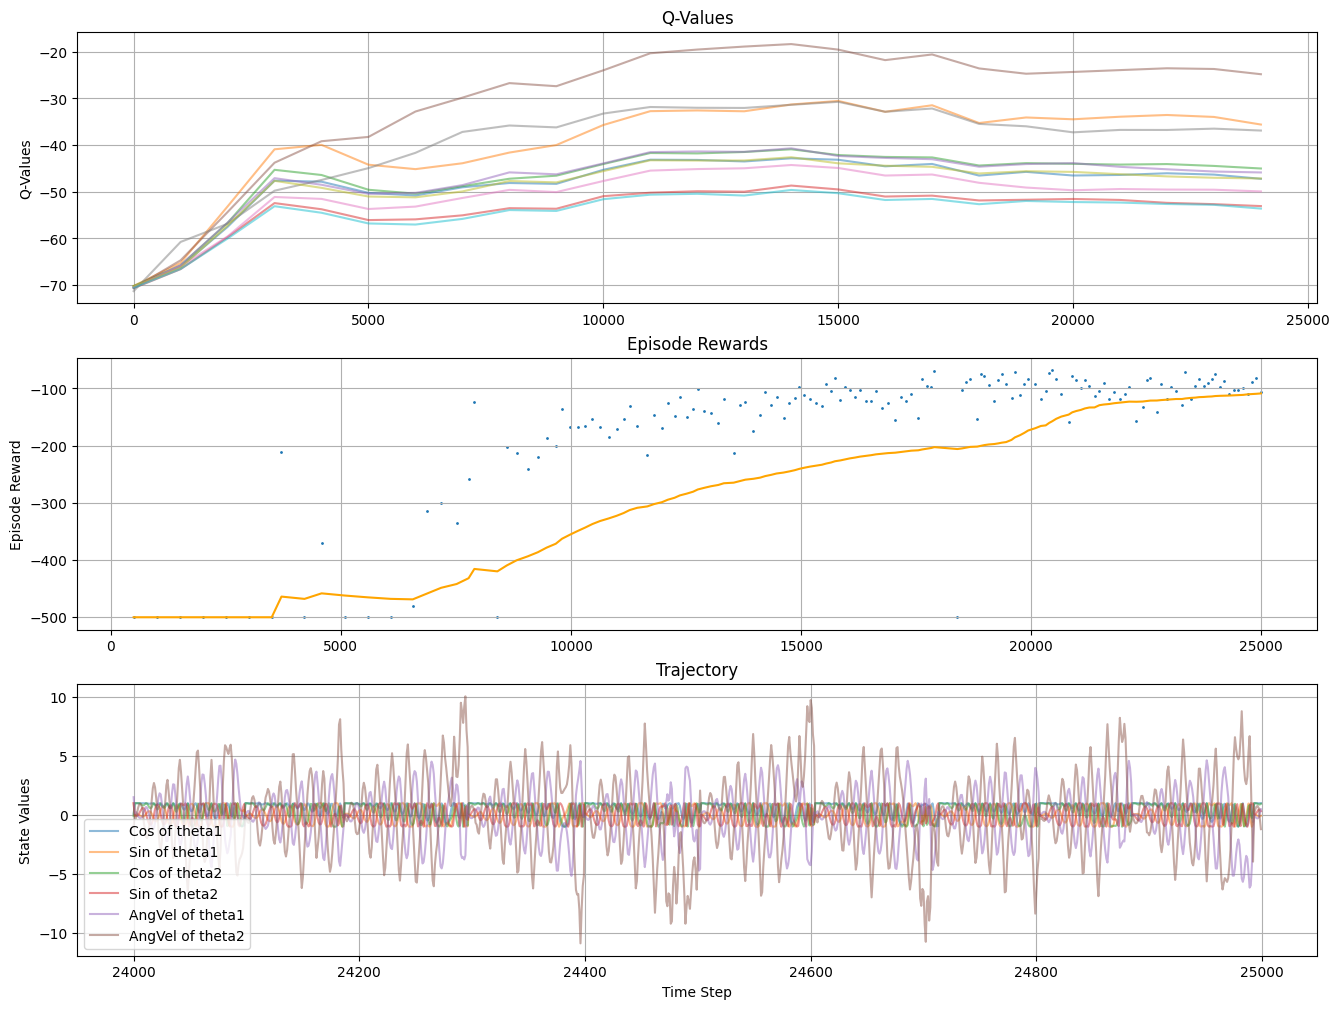

In [172]:
helpers.plot_all(env, model, mem, trace, print_=True)

И посмотрим на анимацию объекта

In [173]:
model._model.save('./tf_models/Acrobot.ckpt')
model._model.load('./tf_models/Acrobot.ckpt')

try: evaluate(env, model, frames=float('inf'), eps=0.0, render=True)
except KeyboardInterrupt: pass
finally: env.close()

INFO:tensorflow:Restoring parameters from ./tf_models/Acrobot.ckpt


In [84]:
print(trace.q_values.values())

odict_values([array([[-69.73704 , -70.674034, -70.846794],
       [-73.22237 , -72.07949 , -64.876945],
       [-71.77788 , -72.09482 , -68.07084 ],
       [-70.65233 , -71.14108 , -70.82878 ],
       [-72.10479 , -72.87201 , -68.27114 ],
       [-72.546616, -72.91055 , -67.48266 ],
       [-71.11872 , -71.50934 , -70.32885 ],
       [-72.06913 , -72.47953 , -68.32476 ],
       [-71.68202 , -72.672905, -69.37525 ],
       [-72.053925, -72.85134 , -68.25711 ]], dtype=float32), array([[-62.320133, -61.925114, -61.86512 ],
       [-63.179276, -64.882805, -64.411354],
       [-54.84397 , -54.230774, -55.562035],
       [-63.60801 , -63.68215 , -63.455112],
       [-66.988045, -67.072685, -67.18004 ],
       [-66.587395, -66.74128 , -66.48004 ],
       [-60.489555, -59.9509  , -59.481804],
       [-66.462776, -66.49587 , -66.38811 ],
       [-63.993126, -63.6543  , -64.05319 ],
       [-67.12024 , -67.19112 , -67.163795]], dtype=float32), array([[-49.69721 , -48.774044, -47.546352],
       

[array([ 0.9974589 , -0.07124429,  0.9966649 ,  0.08160359,  0.06110764,
       -0.01941227], dtype=float32), array([ 0.99803466, -0.06266486,  0.995238  ,  0.0974745 ,  0.0237507 ,
        0.17710266], dtype=float32), array([ 0.9980953 , -0.06169133,  0.9887194 ,  0.14977944, -0.01238458,
        0.3408235 ], dtype=float32), array([ 0.99778676, -0.06649482,  0.9738966 ,  0.22699212, -0.03218712,
        0.43115658], dtype=float32), array([ 0.998203  , -0.05992354,  0.96032006,  0.27890036,  0.0977444 ,
        0.09839424], dtype=float32), array([ 0.99912304, -0.04187033,  0.9547303 ,  0.29747277,  0.0799018 ,
        0.09517805], dtype=float32), array([ 0.9999951 , -0.0031306 ,  0.9681515 ,  0.2503651 ,  0.29842207,
       -0.57132965], dtype=float32), array([ 0.9982956 ,  0.05836027,  0.9930046 ,  0.11807569,  0.30046842,
       -0.7435889 ], dtype=float32), array([ 0.99238765,  0.12315353,  0.9979243 , -0.06439736,  0.3310206 ,
       -1.0421163 ], dtype=float32), array([ 0.9857155 

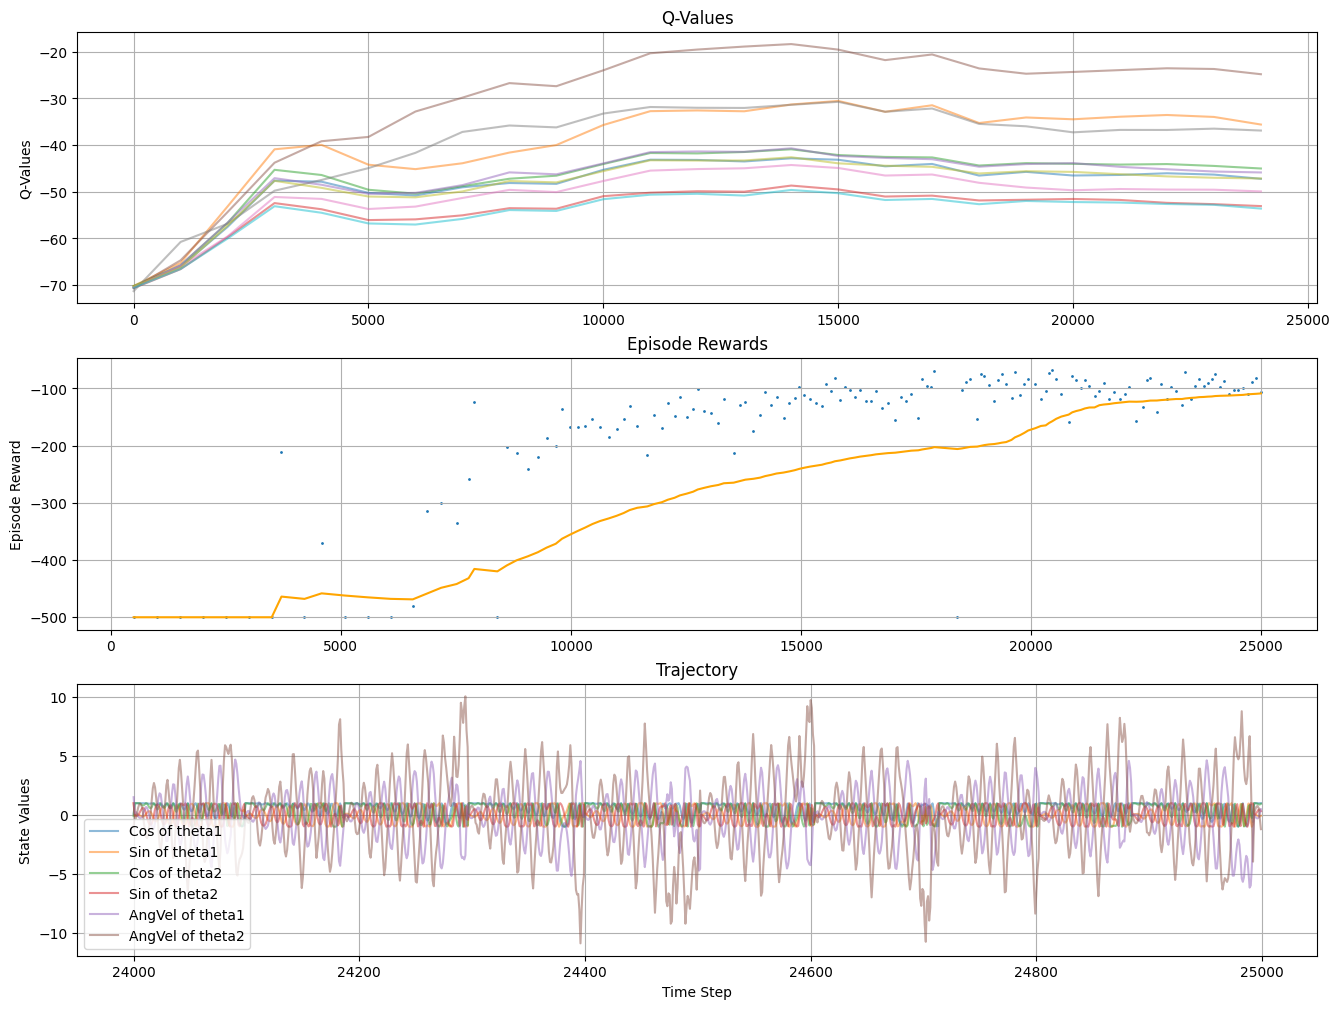

In [174]:
helpers.plot_all(env, model, mem, trace, print_=True)

In [177]:
env.render()
print(env.states())

AttributeError: 'AcrobotEnv' object has no attribute 'states'